## Training for Synth Paper 2022

### Loading data

In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
import timm

import albumentations as albu
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# helper function for data visualization
def visualize(label, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        #plt.title(' '.join(name.split('_')).title())
        plt.title(f'{name.title()} | GT: {label}')
        plt.imshow(image)
    plt.show()

### Data Preparation

In [4]:
df = pd.read_csv('synth_paper_data.csv')
df['class'] = df['class'].astype('category')

In [5]:
df.sample(5)

,file_path,file_name,source,split,class,label_encoded
18009,../../data/generated_data/cs_uu/covid/sample_6...,sample_6626.png,Synth,train,C,1
30924,../../data/Covidx/data_with_classes/train/norm...,f27252da-ac5d-46b2-8df9-32e09763574b.png,Covidx,train,H,3
3671,../../data/generated_data/cs_uu/nb/sample_1931...,sample_1931.png,Synth,train,H,3
27725,../../data/Covidx/data_with_classes/train/norm...,b33610c9-a152-47f8-8ee5-4f81dce62938.png,Covidx,train,H,3
30891,../../data/Covidx/data_with_classes/train/norm...,4cced631-6710-435c-b822-e7880a448a63.png,Covidx,train,H,3


In [6]:
df['source'].unique()

array(['UKU_old_split', 'UKU_all', 'Synth', 'Covidx'], dtype=object)

In [7]:
df.loc[df['source']=='UKU_all','class'].value_counts()

H    673
F    125
C    110
B    100
V     74
Name: class, dtype: int64

In [8]:
df_uku_binary = df.loc[df['source']=='UKU_all'].copy()

In [9]:
cls_map = {'C' : 'P',
           'H' : 'H',
           'V' : 'P',
           'F' : 'P',
           'B' : 'P'}

In [10]:
df_uku_binary['class'] = df_uku_binary['class'].map(cls_map)

In [11]:
df_uku_binary['class'] = df_uku_binary['class'].astype('category')
df_uku_binary['label_encoded'] = df_uku_binary['class'].cat.codes.astype('int64')

In [12]:
df_uku_binary['split'].value_counts()

train    865
test     217
Name: split, dtype: int64

In [13]:
pd.pivot_table(df_uku_binary,values=['file_name'],index=['split'],columns=['class'],aggfunc='count')

file_name     
class         H    P
split               
test        135   82
train       538  327

In [14]:
df_uku_binary.head()

,file_path,file_name,source,split,class,label_encoded
333,../../data/segmentation_test/raw/C59.png,C59.png,UKU_all,train,P,1
334,../../data/segmentation_test/raw/NB46.png,NB46.png,UKU_all,train,H,0
335,../../data/segmentation_test/raw/NB663.png,NB663.png,UKU_all,train,H,0
336,../../data/segmentation_test/raw/V29.png,V29.png,UKU_all,train,P,1
337,../../data/segmentation_test/raw/NB626.png,NB626.png,UKU_all,train,H,0


Split on patients to avoid overlap:

In [15]:
patients = pd.read_csv('../../data/segmentation_test/image_details_full.csv')

In [16]:
df_uku_binary_patients = pd.merge(df_uku_binary,patients,on='file_name')

In [17]:
df_uku_binary_patients.drop('class_y',axis=1,inplace=True)
df_uku_binary_patients.rename(columns={'class_x':'class'},inplace=True)

In [18]:
train_pat_ids, valid_pat_ids = train_test_split(df_uku_binary_patients['patient_id'].unique(),test_size=0.2, random_state=14)

In [19]:
df_uku_binary_patients['patient_id'].isin(train_pat_ids).value_counts()

True     867
False    215
Name: patient_id, dtype: int64

In [20]:
df_uku_binary_patients['split'].value_counts()

train    865
test     217
Name: split, dtype: int64

In [21]:
df_uku_binary_patients.loc[df_uku_binary_patients['patient_id'].isin(train_pat_ids),'class'].value_counts()/len(df_uku_binary_patients)

H    0.489834
P    0.311460
Name: class, dtype: float64

In [22]:
df_uku_binary_patients['class'].value_counts()/len(df_uku_binary_patients)

H    0.621996
P    0.378004
Name: class, dtype: float64

In [23]:
df_uku_binary_patients.loc[df_uku_binary_patients['patient_id'].isin(train_pat_ids),'patient_split'] = 'train'

In [24]:
df_uku_binary_patients.loc[df_uku_binary_patients['patient_id'].isin(valid_pat_ids),'patient_split'] = 'test'

In [25]:
df_uku_binary_patients.head()

,file_path,file_name,source,split,class,label_encoded,patient_id,patient_split
0,../../data/segmentation_test/raw/C59.png,C59.png,UKU_all,train,P,1,C57,train
1,../../data/segmentation_test/raw/NB46.png,NB46.png,UKU_all,train,H,0,NB46,test
2,../../data/segmentation_test/raw/NB663.png,NB663.png,UKU_all,train,H,0,NB663,train
3,../../data/segmentation_test/raw/V29.png,V29.png,UKU_all,train,P,1,V23,train
4,../../data/segmentation_test/raw/NB626.png,NB626.png,UKU_all,train,H,0,NB626,train


Dataloader:

In [26]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations."""
    
    def __init__(
            self,
            df, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.df = df.reset_index(drop=True)
        self.ids = self.df.loc[:,'file_path'].values
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.ids[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)   
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']
        
        label = self.df.loc[i,'label_encoded']
        
        return image, label
        
    def __len__(self):
        return len(self.ids)

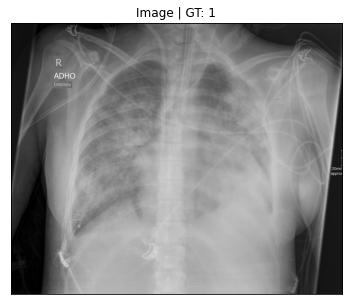

In [27]:
dataset = Dataset(df_uku_binary_patients)

image, label = dataset[3] # get some sample
visualize(
    label=label,
    image=image
)

### Augmentations

In [28]:
image_size = 224

In [29]:
def get_training_augmentation():
    train_transform = [
        
        albu.RandomResizedCrop(height=image_size, width=image_size, scale=(0.25, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=1, p=1.0),
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),


        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #albu.PadIfNeeded(384, 480)
        albu.Resize(image_size, image_size),
        #albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD,max_pixel_value=255.0),
        albu.Lambda(image=to_tensor),
    ]
    return albu.Compose(_transform)

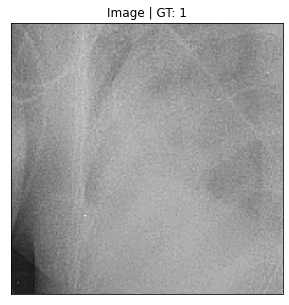

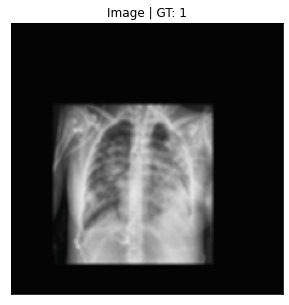

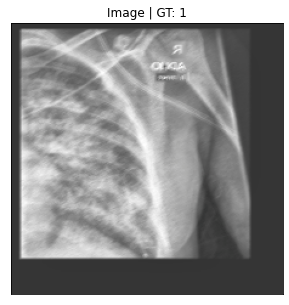

In [30]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    df_uku_binary_patients, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, label = augmented_dataset[3]
    visualize(label=label,image=image)

### Create model and train

Define model

In [31]:
dropout = False
dropout_percent = 0.5
num_classes = 2

In [32]:
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model.get_classifier().in_features
if dropout:
    model.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model.fc = nn.Linear(num_ftrs, num_classes)

model = model.to(device) 

Define Loss function and optimizer

In [33]:
epochs = 40
val_loss_min = np.Inf

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs-1)

scaler = torch.cuda.amp.GradScaler()

In [37]:
train_dataset = Dataset(
    df_uku_binary_patients.loc[df_uku_binary_patients['patient_split']=='train',:],
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing()
)

valid_dataset = Dataset(
    df_uku_binary_patients.loc[df_uku_binary_patients['patient_split']=='test',:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [38]:
ckpt_dir = './models'
CHECKPOINT = f'{ckpt_dir}/resnet50_synth_uku_all_binary_patient_split.pth'

In [39]:
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_running_corrects = 0
    val_running_corrects = 0
    
    loop = tqdm(train_loader)
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            train_loss.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            train_running_corrects += torch.sum(predicted == labels.data)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        scheduler.step()

        loop.set_description('Epoch {:02d}/{:02d} | LR: {:.5f}'.format(epoch, epochs-1, optimizer.param_groups[0]['lr']))
        loop.set_postfix(loss=np.mean(train_loss))

    train_loss = np.mean(train_loss)
    train_epoch_acc = train_running_corrects.double() / len(train_loader.dataset)
    
    model.eval()

    val_loss = 0

    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(), torch.no_grad():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            #_,labels = torch.max(labels.data, 1)
            val_running_corrects += torch.sum(predicted == labels.data)

    val_loss /= len(valid_loader.dataset)
    val_epoch_acc = val_running_corrects.double() / len(valid_loader.dataset)
    
    print(f'train loss: {train_loss:.5f} | train acc: {train_epoch_acc:.3f} | val_loss: {val_loss:.5f} | val acc: {val_epoch_acc:.3f}')
    
    if val_loss < val_loss_min:
            print(f'Valid loss improved from {val_loss_min:.5f} to {val_loss:.5f} saving model to {CHECKPOINT}')
            val_loss_min = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), CHECKPOINT)
    
    print(f'Best epoch {best_epoch} | val loss min: {val_loss_min:.5f}')

Epoch 00/39 | LR: 0.00004: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s, loss=0.413]
100%|██████████| 215/215 [00:07<00:00, 30.01it/s]


train loss: 0.41329 | train acc: 0.827 | val_loss: 0.20018 | val acc: 0.940
Valid loss improved from inf to 0.20018 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 0 | val loss min: 0.20018


Epoch 01/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.05it/s, loss=0.343]
100%|██████████| 215/215 [00:07<00:00, 29.82it/s]


train loss: 0.34257 | train acc: 0.855 | val_loss: 0.17809 | val acc: 0.940
Valid loss improved from 0.20018 to 0.17809 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 1 | val loss min: 0.17809


Epoch 02/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  3.93it/s, loss=0.263]
100%|██████████| 215/215 [00:07<00:00, 30.03it/s]


train loss: 0.26326 | train acc: 0.896 | val_loss: 0.14712 | val acc: 0.953
Valid loss improved from 0.17809 to 0.14712 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 2 | val loss min: 0.14712


Epoch 03/39 | LR: 0.00007: 100%|██████████| 55/55 [00:13<00:00,  4.18it/s, loss=0.274]
100%|██████████| 215/215 [00:07<00:00, 29.93it/s]


train loss: 0.27403 | train acc: 0.893 | val_loss: 0.19533 | val acc: 0.930
Best epoch 2 | val loss min: 0.14712


Epoch 04/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s, loss=0.253]
100%|██████████| 215/215 [00:07<00:00, 29.95it/s]


train loss: 0.25339 | train acc: 0.920 | val_loss: 0.12304 | val acc: 0.958
Valid loss improved from 0.14712 to 0.12304 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 4 | val loss min: 0.12304


Epoch 05/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  4.14it/s, loss=0.225]
100%|██████████| 215/215 [00:07<00:00, 29.79it/s]


train loss: 0.22539 | train acc: 0.915 | val_loss: 0.14785 | val acc: 0.958
Best epoch 4 | val loss min: 0.12304


Epoch 06/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s, loss=0.234]
100%|██████████| 215/215 [00:07<00:00, 29.84it/s]


train loss: 0.23356 | train acc: 0.915 | val_loss: 0.11401 | val acc: 0.963
Valid loss improved from 0.12304 to 0.11401 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 6 | val loss min: 0.11401


Epoch 07/39 | LR: 0.00002: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s, loss=0.245]
100%|██████████| 215/215 [00:07<00:00, 29.81it/s]


train loss: 0.24520 | train acc: 0.905 | val_loss: 0.14320 | val acc: 0.940
Best epoch 6 | val loss min: 0.11401


Epoch 08/39 | LR: 0.00002: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s, loss=0.237]
100%|██████████| 215/215 [00:07<00:00, 29.79it/s]


train loss: 0.23705 | train acc: 0.908 | val_loss: 0.11255 | val acc: 0.967
Valid loss improved from 0.11401 to 0.11255 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 8 | val loss min: 0.11255


Epoch 09/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.06it/s, loss=0.208]
100%|██████████| 215/215 [00:07<00:00, 29.79it/s]


train loss: 0.20798 | train acc: 0.919 | val_loss: 0.15572 | val acc: 0.926
Best epoch 8 | val loss min: 0.11255


Epoch 10/39 | LR: 0.00005: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s, loss=0.23] 
100%|██████████| 215/215 [00:07<00:00, 29.67it/s]


train loss: 0.23018 | train acc: 0.910 | val_loss: 0.12024 | val acc: 0.953
Best epoch 8 | val loss min: 0.11255


Epoch 11/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  3.96it/s, loss=0.214]
100%|██████████| 215/215 [00:07<00:00, 28.21it/s]


train loss: 0.21433 | train acc: 0.919 | val_loss: 0.12319 | val acc: 0.967
Best epoch 8 | val loss min: 0.11255


Epoch 12/39 | LR: 0.00007: 100%|██████████| 55/55 [00:13<00:00,  3.97it/s, loss=0.192]
100%|██████████| 215/215 [00:07<00:00, 29.64it/s]


train loss: 0.19178 | train acc: 0.934 | val_loss: 0.13040 | val acc: 0.953
Best epoch 8 | val loss min: 0.11255


Epoch 13/39 | LR: 0.00008: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s, loss=0.19] 
100%|██████████| 215/215 [00:07<00:00, 30.09it/s]


train loss: 0.18952 | train acc: 0.934 | val_loss: 0.10595 | val acc: 0.958
Valid loss improved from 0.11255 to 0.10595 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 13 | val loss min: 0.10595


Epoch 14/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.13it/s, loss=0.204]
100%|██████████| 215/215 [00:07<00:00, 30.09it/s]


train loss: 0.20365 | train acc: 0.927 | val_loss: 0.09910 | val acc: 0.967
Valid loss improved from 0.10595 to 0.09910 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 14 | val loss min: 0.09910


Epoch 15/39 | LR: 0.00004: 100%|██████████| 55/55 [00:13<00:00,  4.10it/s, loss=0.215]
100%|██████████| 215/215 [00:07<00:00, 29.93it/s]


train loss: 0.21543 | train acc: 0.930 | val_loss: 0.08216 | val acc: 0.981
Valid loss improved from 0.09910 to 0.08216 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 15 | val loss min: 0.08216


Epoch 16/39 | LR: 0.00010: 100%|██████████| 55/55 [00:14<00:00,  3.83it/s, loss=0.177]
100%|██████████| 215/215 [00:07<00:00, 29.63it/s]


train loss: 0.17737 | train acc: 0.928 | val_loss: 0.08561 | val acc: 0.972
Best epoch 15 | val loss min: 0.08216


Epoch 17/39 | LR: 0.00003: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s, loss=0.18] 
100%|██████████| 215/215 [00:07<00:00, 29.54it/s]


train loss: 0.18013 | train acc: 0.927 | val_loss: 0.08018 | val acc: 0.967
Valid loss improved from 0.08216 to 0.08018 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 17 | val loss min: 0.08018


Epoch 18/39 | LR: 0.00001: 100%|██████████| 55/55 [00:14<00:00,  3.88it/s, loss=0.174]
100%|██████████| 215/215 [00:07<00:00, 29.76it/s]


train loss: 0.17443 | train acc: 0.942 | val_loss: 0.10288 | val acc: 0.972
Best epoch 17 | val loss min: 0.08018


Epoch 19/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  3.99it/s, loss=0.132]
100%|██████████| 215/215 [00:07<00:00, 29.58it/s]


train loss: 0.13185 | train acc: 0.953 | val_loss: 0.16891 | val acc: 0.953
Best epoch 17 | val loss min: 0.08018


Epoch 20/39 | LR: 0.00007: 100%|██████████| 55/55 [00:13<00:00,  4.03it/s, loss=0.216]
100%|██████████| 215/215 [00:07<00:00, 29.90it/s]


train loss: 0.21610 | train acc: 0.918 | val_loss: 0.09149 | val acc: 0.953
Best epoch 17 | val loss min: 0.08018


Epoch 21/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s, loss=0.228]
100%|██████████| 215/215 [00:07<00:00, 29.79it/s]


train loss: 0.22812 | train acc: 0.917 | val_loss: 0.12668 | val acc: 0.940
Best epoch 17 | val loss min: 0.08018


Epoch 22/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s, loss=0.191]
100%|██████████| 215/215 [00:07<00:00, 29.84it/s]


train loss: 0.19103 | train acc: 0.926 | val_loss: 0.09733 | val acc: 0.958
Best epoch 17 | val loss min: 0.08018


Epoch 23/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  4.00it/s, loss=0.165]
100%|██████████| 215/215 [00:07<00:00, 29.85it/s]


train loss: 0.16524 | train acc: 0.941 | val_loss: 0.11711 | val acc: 0.953
Best epoch 17 | val loss min: 0.08018


Epoch 24/39 | LR: 0.00002: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s, loss=0.203]
100%|██████████| 215/215 [00:07<00:00, 29.76it/s]


train loss: 0.20268 | train acc: 0.913 | val_loss: 0.10221 | val acc: 0.958
Best epoch 17 | val loss min: 0.08018


Epoch 25/39 | LR: 0.00002: 100%|██████████| 55/55 [00:14<00:00,  3.91it/s, loss=0.176]
100%|██████████| 215/215 [00:07<00:00, 30.18it/s]


train loss: 0.17556 | train acc: 0.945 | val_loss: 0.07623 | val acc: 0.967
Valid loss improved from 0.08018 to 0.07623 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 25 | val loss min: 0.07623


Epoch 26/39 | LR: 0.00010: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s, loss=0.134]
100%|██████████| 215/215 [00:07<00:00, 30.25it/s]


train loss: 0.13424 | train acc: 0.953 | val_loss: 0.10057 | val acc: 0.967
Best epoch 25 | val loss min: 0.07623


Epoch 27/39 | LR: 0.00005: 100%|██████████| 55/55 [00:13<00:00,  4.11it/s, loss=0.143]
100%|██████████| 215/215 [00:07<00:00, 30.20it/s]


train loss: 0.14289 | train acc: 0.941 | val_loss: 0.07967 | val acc: 0.977
Best epoch 25 | val loss min: 0.07623


Epoch 28/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  3.95it/s, loss=0.162] 
100%|██████████| 215/215 [00:07<00:00, 30.17it/s]


train loss: 0.16191 | train acc: 0.938 | val_loss: 0.07589 | val acc: 0.977
Valid loss improved from 0.07623 to 0.07589 saving model to ./models/resnet50_synth_uku_all_binary_patient_split.pth
Best epoch 28 | val loss min: 0.07589


Epoch 29/39 | LR: 0.00008: 100%|██████████| 55/55 [00:13<00:00,  4.12it/s, loss=0.154]
100%|██████████| 215/215 [00:07<00:00, 29.83it/s]


train loss: 0.15384 | train acc: 0.945 | val_loss: 0.11490 | val acc: 0.949
Best epoch 28 | val loss min: 0.07589


Epoch 30/39 | LR: 0.00008: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s, loss=0.144]
100%|██████████| 215/215 [00:07<00:00, 30.22it/s]


train loss: 0.14444 | train acc: 0.948 | val_loss: 0.07690 | val acc: 0.963
Best epoch 28 | val loss min: 0.07589


Epoch 31/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  4.04it/s, loss=0.159] 
100%|██████████| 215/215 [00:07<00:00, 30.34it/s]


train loss: 0.15906 | train acc: 0.949 | val_loss: 0.07711 | val acc: 0.972
Best epoch 28 | val loss min: 0.07589


Epoch 32/39 | LR: 0.00004: 100%|██████████| 55/55 [00:13<00:00,  4.02it/s, loss=0.133]
100%|██████████| 215/215 [00:07<00:00, 30.24it/s]


train loss: 0.13280 | train acc: 0.950 | val_loss: 0.10075 | val acc: 0.958
Best epoch 28 | val loss min: 0.07589


Epoch 33/39 | LR: 0.00010: 100%|██████████| 55/55 [00:13<00:00,  4.01it/s, loss=0.169] 
100%|██████████| 215/215 [00:07<00:00, 30.16it/s]


train loss: 0.16859 | train acc: 0.940 | val_loss: 0.08925 | val acc: 0.963
Best epoch 28 | val loss min: 0.07589


Epoch 34/39 | LR: 0.00003: 100%|██████████| 55/55 [00:13<00:00,  4.07it/s, loss=0.191]
100%|██████████| 215/215 [00:07<00:00, 30.05it/s]


train loss: 0.19122 | train acc: 0.932 | val_loss: 0.12071 | val acc: 0.963
Best epoch 28 | val loss min: 0.07589


Epoch 35/39 | LR: 0.00001: 100%|██████████| 55/55 [00:13<00:00,  4.21it/s, loss=0.162]
100%|██████████| 215/215 [00:07<00:00, 30.18it/s]


train loss: 0.16158 | train acc: 0.934 | val_loss: 0.10984 | val acc: 0.963
Best epoch 28 | val loss min: 0.07589


Epoch 36/39 | LR: 0.00009: 100%|██████████| 55/55 [00:13<00:00,  4.16it/s, loss=0.144]
100%|██████████| 215/215 [00:07<00:00, 30.25it/s]


train loss: 0.14427 | train acc: 0.952 | val_loss: 0.08539 | val acc: 0.977
Best epoch 28 | val loss min: 0.07589


Epoch 37/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  3.98it/s, loss=0.125] 
100%|██████████| 215/215 [00:07<00:00, 30.35it/s]


train loss: 0.12489 | train acc: 0.956 | val_loss: 0.07849 | val acc: 0.967
Best epoch 28 | val loss min: 0.07589


Epoch 38/39 | LR: 0.00000: 100%|██████████| 55/55 [00:13<00:00,  3.94it/s, loss=0.13] 
100%|██████████| 215/215 [00:07<00:00, 30.26it/s]


train loss: 0.12961 | train acc: 0.957 | val_loss: 0.07821 | val acc: 0.963
Best epoch 28 | val loss min: 0.07589


Epoch 39/39 | LR: 0.00006: 100%|██████████| 55/55 [00:13<00:00,  4.09it/s, loss=0.111] 
100%|██████████| 215/215 [00:07<00:00, 30.19it/s]

train loss: 0.11083 | train acc: 0.964 | val_loss: 0.07635 | val acc: 0.977
Best epoch 28 | val loss min: 0.07589


### Visualize predictions

In [40]:
model_inf = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
num_ftrs = model_inf.get_classifier().in_features
if dropout:
    model_inf.fc = nn.Sequential(
                            nn.Dropout(dropout_percent),
                            nn.Linear(num_ftrs,num_classes)
    )
else:
    model_inf.fc = nn.Linear(num_ftrs, num_classes)

model_inf.load_state_dict(torch.load(CHECKPOINT))
model_inf.to(device) 
model_inf = model_inf.eval()

In [41]:
valid_dataset = Dataset(
    df_uku_binary_patients.loc[df_uku_binary_patients['patient_split']=='test',:], 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(),
)

#### Validation data

In [42]:
# For confusion matrix
label_array = np.array([], dtype='int64')
prediction_array = np.array([], dtype='int64')

In [43]:
with torch.no_grad():
    model_inf.eval()
    for images, labels in valid_dataset:
        images = torch.from_numpy(images).to(device).unsqueeze(0)
        #labels = labels.to(device)
        
        cls_outputs = model_inf(images)
        _, predicted = torch.max(cls_outputs.data, 1)
        #_,labels = torch.max(labels.data, 0)
        label_array = np.append(label_array, labels)
        prediction_array = np.append(prediction_array, predicted.detach().cpu().numpy())

In [44]:
%matplotlib inline

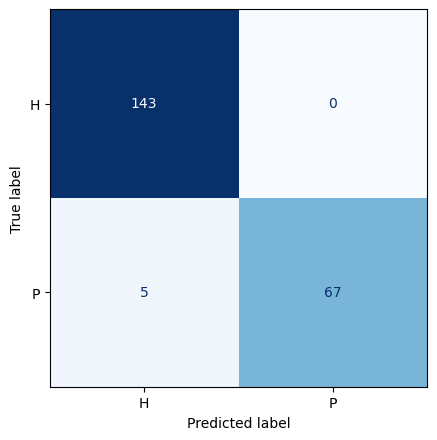

In [45]:
fig, ax = plt.subplots(figsize=(8,5),dpi=100)
ConfusionMatrixDisplay.from_predictions(label_array,prediction_array,display_labels=['H','P'],cmap='Blues',colorbar=False,ax=ax)
plt.show()

In [46]:
print(classification_report(label_array, prediction_array, digits=4,target_names=['H','P']))

              precision    recall  f1-score   support

           H     0.9662    1.0000    0.9828       143
           P     1.0000    0.9306    0.9640        72

    accuracy                         0.9767       215
   macro avg     0.9831    0.9653    0.9734       215
weighted avg     0.9775    0.9767    0.9765       215

